## Notebook Import

In [128]:
from os.path import join
import sys
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

In [29]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Constants

In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/IMDB_Movie_Reviews'

## Reading Data

In [149]:
reviews_path = join(data_path, 'IMDB_Dataset.csv')

reviews_df = pd.read_csv(reviews_path)

## Explore Data

In [7]:
reviews_df.shape

(50000, 2)

In [8]:
reviews_df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Data Cleaning: checking for missing values

In [10]:
reviews_df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
(reviews_df.review.str.len() == 0).sum()

0

## Data Visualisation

In [12]:
reviews_df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

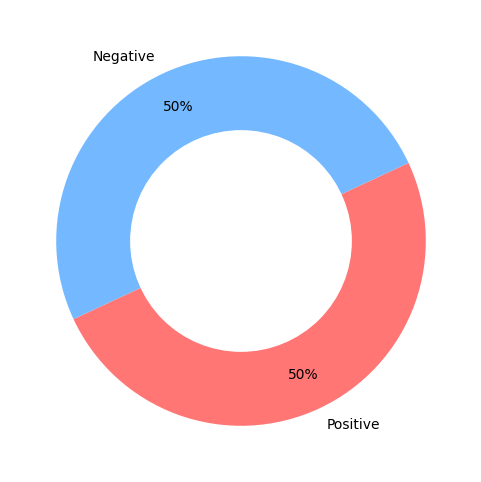

In [14]:
sizes = [reviews_df['sentiment'].value_counts()[0], reviews_df['sentiment'].value_counts()[1]]
labels = ['Positive', 'Negative']

explode = (0.05, 0.05)


plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=['#ff7675', '#74b9ff'],
        startangle=205, textprops={'fontsize':10}, pctdistance=0.8,)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)


plt.show()

## Load NumPy arrays with tf.data.Dataset

In [150]:
reviews_df['sentiment'] = reviews_df['sentiment'].map({'positive': 1, 'negative': 0})
raw_dev, raw_test, dev_label, test_label  =train_test_split(reviews_df['review'], reviews_df['sentiment'], test_size=0.2, random_state=42)

raw_train, raw_val, train_label, val_label = train_test_split(raw_dev, dev_label, test_size=0.2, random_state=42)

BATCH_SIZE = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices((raw_train, train_label)).batch(BATCH_SIZE)
raw_val_ds = tf.data.Dataset.from_tensor_slices((raw_val, val_label)).batch(BATCH_SIZE)
raw_test_ds = tf.data.Dataset.from_tensor_slices((raw_test, test_label)).batch(BATCH_SIZE)


In [121]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"With no fault to the actors (they all put on great performances), the overall story was not very well executed. The movie opens with a great zinger: a crazy old guy forces a young Aborigine girl's car off the road. But then, we're forced to endure 40 minutes of character development with an entirely new group of characters ... and we don't know why until the 40 minutes are up. It turns out that they are the ones who eventually discover the girl's body ... and the story progresses from there.<br /><br />While the story does pick up at that point, it really goes nowhere. After 2 hours, I asked myself: was there a point to this, or was it just to see the characters struggle with accusations of racism and stupidity of how they handled the discovery? The story was ultimately unsatisfying and felt unfinished. While it is well acted, there's not a strong enough backbone in the film to warrant recommending it."
Label 0
Review b'The first thing I thought when I saw this films was: It i

## Prepare the dataset for training

In [122]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [138]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [139]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [140]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [141]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review.numpy())
print("Label", first_label.numpy())
print("Vectorized review", vectorize_text(first_review, first_label))

Review b"With no fault to the actors (they all put on great performances), the overall story was not very well executed. The movie opens with a great zinger: a crazy old guy forces a young Aborigine girl's car off the road. But then, we're forced to endure 40 minutes of character development with an entirely new group of characters ... and we don't know why until the 40 minutes are up. It turns out that they are the ones who eventually discover the girl's body ... and the story progresses from there.<br /><br />While the story does pick up at that point, it really goes nowhere. After 2 hours, I asked myself: was there a point to this, or was it just to see the characters struggle with accusations of racism and stupidity of how they handled the discovery? The story was ultimately unsatisfying and felt unfinished. While it is well acted, there's not a strong enough backbone in the film to warrant recommending it."
Label 0
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=

In [142]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  innocent
 313 --->  night
Vocabulary size: 10000


In [151]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance

In [144]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [145]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout_11 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [146]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train the model

In [147]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1000/1000 [==============================] - 12s 11ms/step - loss: 0.6322 - binary_accuracy: 0.7312 - val_loss: 0.5415 - val_binary_accuracy: 0.8144
Epoch 2/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.4646 - binary_accuracy: 0.8349 - val_loss: 0.4112 - val_binary_accuracy: 0.8544
Epoch 3/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3687 - binary_accuracy: 0.8656 - val_loss: 0.3531 - val_binary_accuracy: 0.8673
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3193 - binary_accuracy: 0.8798 - val_loss: 0.3234 - val_binary_accuracy: 0.8746
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2880 - binary_accuracy: 0.8910 - val_loss: 0.3059 - val_binary_accuracy: 0.8819
Epoch 6/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2652 - binary_accuracy: 0.8992 - val_loss: 0.2954 - val_binary_accuracy: 0.8844
Epoch 7/10
1000/1000 [========================

## Evaluate Model

In [152]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

313/313 [==============================] - 2s 7ms/step - loss: 0.2782 - binary_accuracy: 0.8876
Loss:  0.27820971608161926
Accuracy:  0.8876000046730042


## Create a plot of accuracy and loss over time

In [153]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

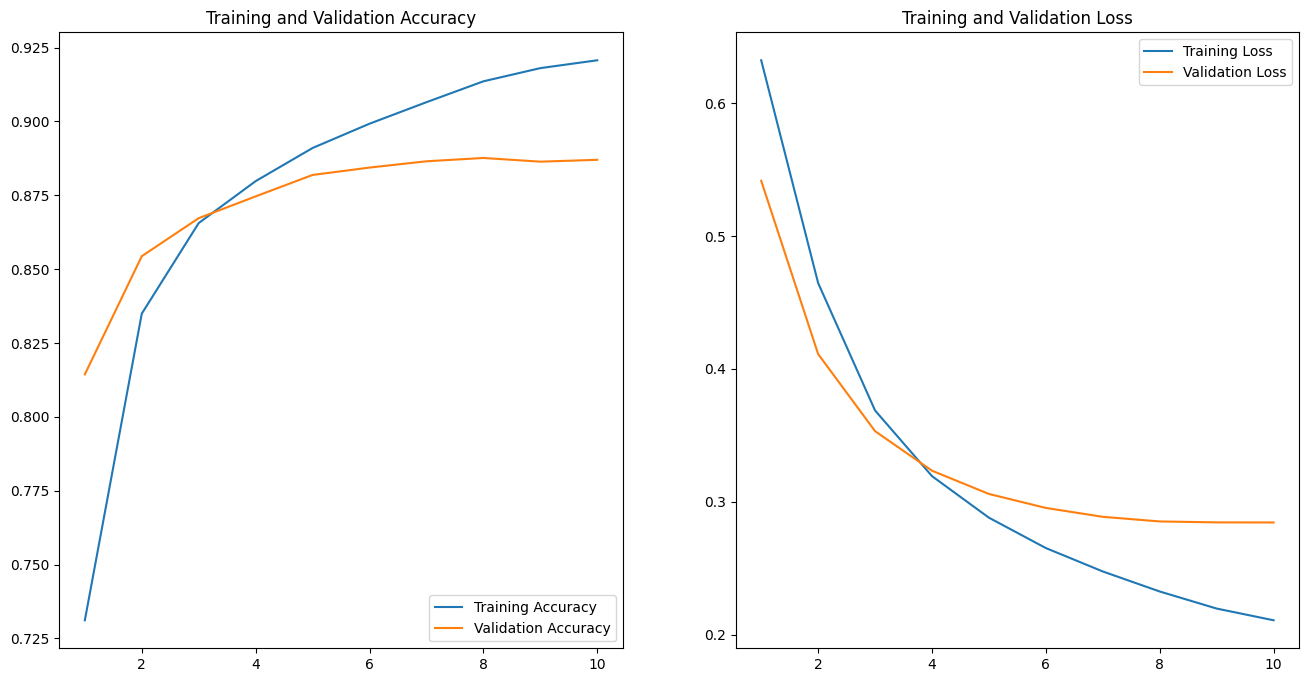

In [160]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Export the model

In [161]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.2782 - accuracy: 0.8876
0.8876000046730042


## Inference on new data

In [162]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 273ms/step


array([[0.6214565 ],
       [0.39940923],
       [0.24930397]], dtype=float32)